In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import calendar
from ast import literal_eval
import json

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

days = list(calendar.day_abbr)
months = list(calendar.month_abbr)

In [3]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#Data Wrangling
#aggregate login counts into 15 minute intervals and construct separate features to denote year, month, day and time.

df['count'] = 1
df = df.set_index('login_time')

In [5]:
df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
ldf = df.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum) 
ldf['count'] = ldf['count'].fillna(0)
ldf.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


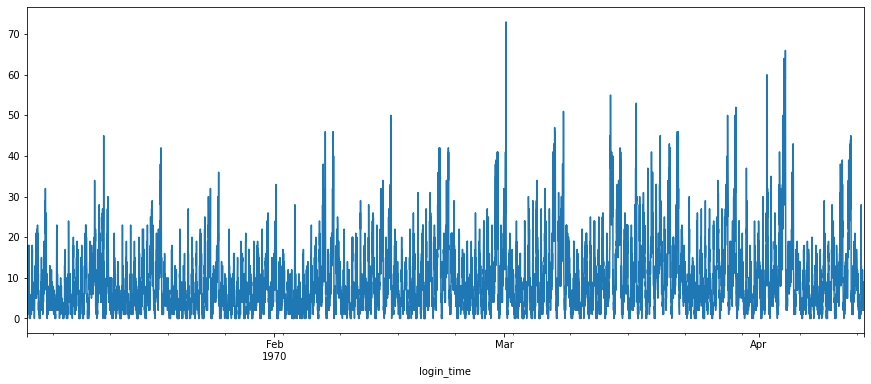

In [7]:
plt.figure(figsize=(15,6))
ldf['count'].plot()

In [8]:
#There is not much we can infer from this graph except for the fact that the login counts seem to be roughly periodic in nature. It would be interesting to discover the periodicity of the above graph.

In [9]:
ldf['timestamp'] = pd.to_datetime(ldf.index)

In [10]:
ldf['month'] = ldf['timestamp'].apply(lambda x: months[x.month])
ldf['day'] = ldf['timestamp'].apply(lambda x: days[x.weekday()])
ldf['hour'] = ldf['timestamp'].apply(lambda x: x.hour)
ldf['time'] = ldf['timestamp'].apply(lambda x: x.time())

In [11]:
ldf.head()

,count,timestamp,month,day,hour,time
login_time,,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,Jan,Thu,20,20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00,Jan,Thu,20,20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00,Jan,Thu,20,20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00,Jan,Thu,20,20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00,Jan,Thu,21,21:00:00


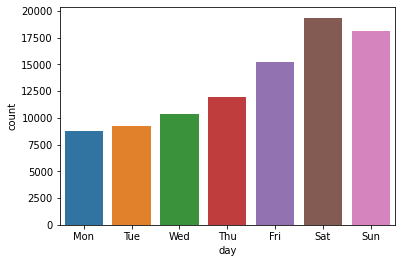

In [12]:
#EDA
#Days
day_counts = ldf.groupby('day')['count'].sum()
sns.barplot(x=day_counts.index, y=day_counts, order=days)

In [13]:
#Observations:
#Saturday is the most popular day for users followed by Sunday and Friday respectively.
#Monday shows the least activity.
#This strongly suggests that users are more active on the platform on the weekends than on the weekdays.

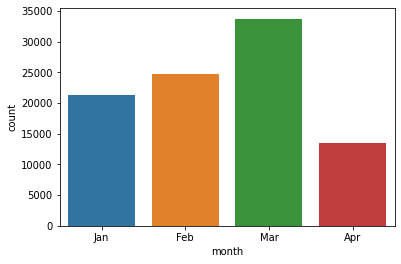

In [14]:
#Months
month_counts = ldf.groupby('month')['count'].sum()
sns.barplot(x=month_counts.index, y=month_counts, order=['Jan', 'Feb', 'Mar', 'Apr'])

In [15]:
#Observations
#Our login counts have been recorded from 1st January, 1970 to 13th April, 1970. We can see that the number of 
#logins has progressively increased over the months (April had just 13 days of activity recorded). This indicates 
#an increasing user base.

In [16]:
#Hours
hour_counts = ldf.groupby('hour')['count'].sum()

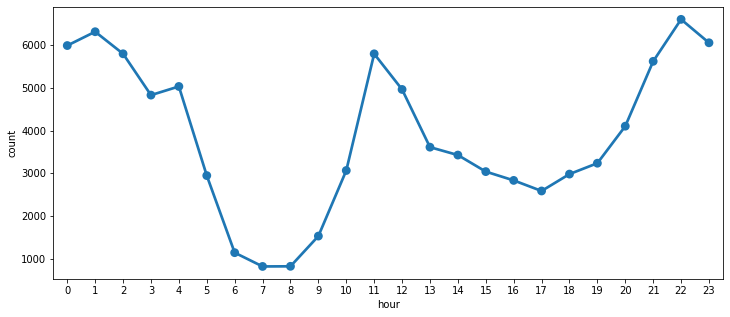

In [17]:
plt.figure(figsize=(12,5))
sns.pointplot(x=hour_counts.index, y=hour_counts)

In [18]:
#The graph above shows us the amount of activity recorded every hour of the day.
#Observations
#The platform records maximum activity between 10 PM and 1 AM.
#There is also a sharp rise in user activity at around noon.
#The least activity is recorded during early morning between 6 AM and 8 AM.

In [19]:
#15 Minute Intervals-amount of activity recorded at every 15 minute interval.
time_counts = ldf.groupby('time')['count'].sum()
time_counts.sort_values(ascending=False).head(10)

time
22:30:00    1684
01:30:00    1673
22:15:00    1652
22:45:00    1637
22:00:00    1634
11:30:00    1622
01:15:00    1598
23:00:00    1573
11:45:00    1570
21:45:00    1554
Name: count, dtype: int64

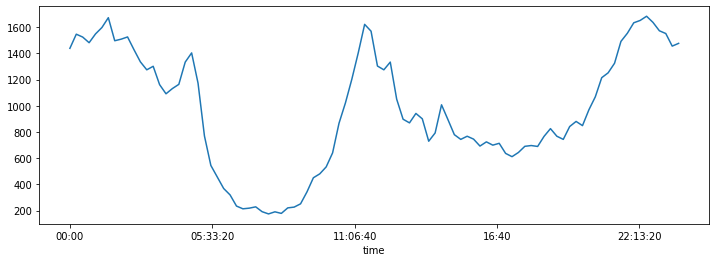

In [20]:
plt.figure(figsize=(12,4))
time_counts.plot()

In [21]:
#The shape of this graph closely mirrors that of the graph obtained in the previous subsection. There is not too much additional insights to be gained from this.

In [22]:
#Experiment and Metrics Design:Part2

In [24]:
#Predictive Modelling
try:
    df2 = pd.read_json('ultimate_data_challenge.json')
except:
    print("Unable to load JSON into Pandas DataFrame")

In [25]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [27]:
df2['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [28]:
#It seems that iPhones are significantly more popular than Android phones. Therefore, we will impute the missing  values with iPhone.
df2['phone'] = df2['phone'].fillna('iPhone')

In [29]:
df2['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

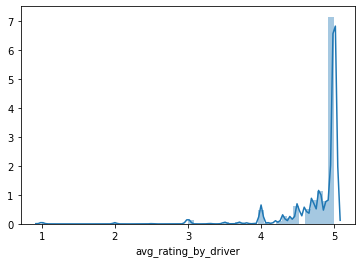

In [30]:
sns.distplot(df2[df2['avg_rating_by_driver'].notnull()]['avg_rating_by_driver'])

In [31]:
#The median rating is 5. We will impute the very few missing values we have with 5.

In [32]:
df2['avg_rating_by_driver'] = df2['avg_rating_by_driver'].fillna(df2['avg_rating_by_driver'].median())

In [33]:
df2['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

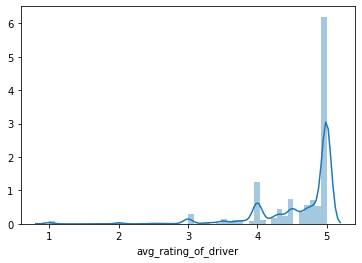

In [34]:
sns.distplot(df2[df2['avg_rating_of_driver'].notnull()]['avg_rating_of_driver'])

In [35]:
#Passengers are slightly less lenient with their ratings than drivers. I will just impute the missing values with the mean.
df2['avg_rating_of_driver'] = df2['avg_rating_of_driver'].fillna(df2['avg_rating_of_driver'].mean())

In [36]:
df2['signup_date'] = df2['signup_date'].apply(lambda x: pd.Timestamp(x, tz=None))
df2['last_trip_date'] = df2['last_trip_date'].apply(lambda x: pd.Timestamp(x, tz=None))

In [37]:
df2['last_trip_date'].sort_values(ascending=False).head(10)

45357   2014-07-01
22735   2014-07-01
14473   2014-07-01
38651   2014-07-01
45126   2014-07-01
14419   2014-07-01
38661   2014-07-01
45143   2014-07-01
45154   2014-07-01
45155   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

In [38]:
df2['retained'] = df2['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)

In [39]:
df2['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [40]:
#We see that Ultimate Inc. has been able to retain 18,804 or 37.6% of its Userbase.
#This retention rate is not that high.
#Since our users have all signed up in January 2014, we can drop it as it doesn't really indicate much.

In [41]:
df2 = df2.drop('signup_date', axis=1)

In [42]:
df2 = df2.drop('last_trip_date', axis=1)

In [43]:
df2['ultimate_black_user'] = df2['ultimate_black_user'].apply(lambda x: 1 if x else 0)

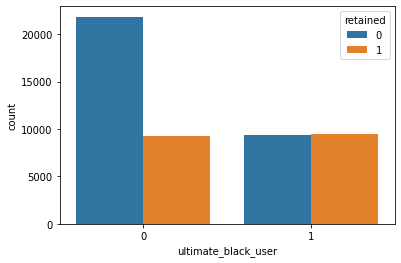

In [44]:
sns.countplot(x='ultimate_black_user', data=df2, hue='retained')

In [45]:
#Ultimate Black Users are much more likely to be retained as compared to the rest of the population.

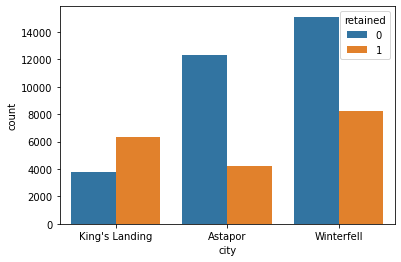

In [46]:
sns.countplot(x='city', data=df2, hue='retained')

In [47]:
#King's Landing seems to be especially successful in retaining users whereas Astapor is the least successful.

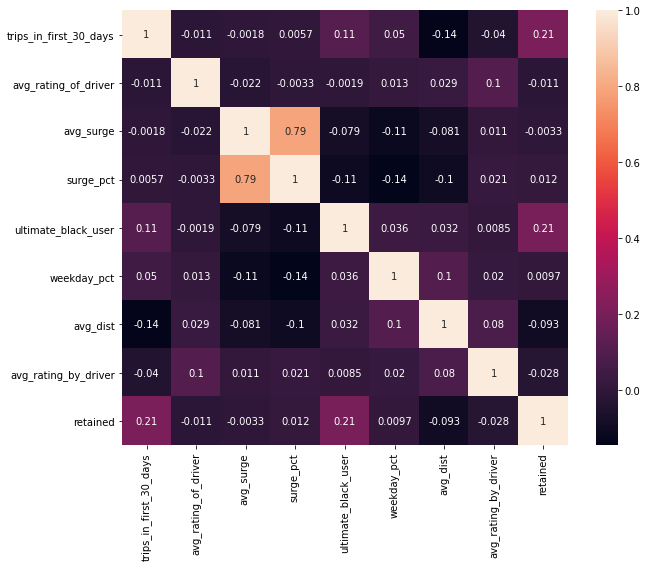

In [48]:
plt.figure(figsize=(10,8))
sns.heatmap(df2.corr(), annot=True)

In [49]:
df2 = pd.get_dummies(df2, prefix='is')

In [50]:
X, y = df2.drop(['retained', 'avg_surge'], axis=1), df2['retained']

In [51]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

In [52]:
classifier = GradientBoostingClassifier(verbose=True, n_estimators=200)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           1.2798            8.70s
         2           1.2438            8.78s
         3           1.2125            8.85s
         4           1.1850            8.20s
         5           1.1631            7.96s
         6           1.1428            8.14s
         7           1.1251            7.94s
         8           1.1099            7.79s
         9           1.0909            7.56s
        10           1.0789            7.44s
        20           0.9974            6.98s
        30           0.9634            6.73s
        40           0.9446            6.30s
        50           0.9334            5.75s
        60           0.9262            5.30s
        70           0.9211            4.94s
        80           0.9172            4.68s
        90           0.9143            4.63s
       100           0.9118            4.16s
       200           0.8904            0.00s


0.7914666666666667

In [53]:
#Our classifier reports an accuracy of 79.1%. The model that we used was the Gradient Boosting Classifier.

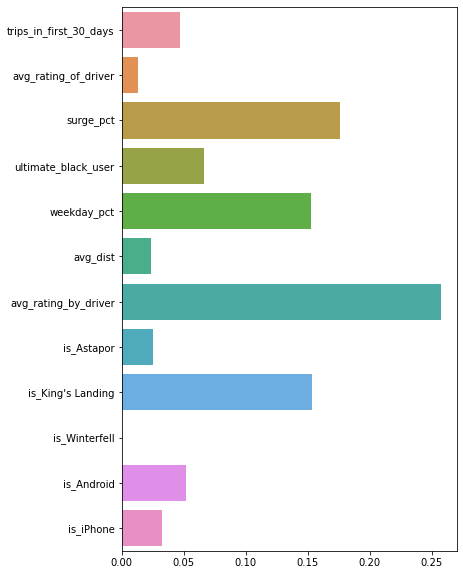

In [54]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_)

In [ ]:
#Recommendations
#Increase operations in King's Landing as they tend to have greater probability of conversion. Alternatively, discover what is unique about King's Landing drivers and passengers and check if it can be implemented in the other cities, especially Astapor.
#If the user has taken a Ultimate Black, it indicates that s/he is more likely to stay. Provide addtional perks to these people.
#People who use cabs on the weekdays are more likely to be retained. This is the most important feature as discovered by our Gradient Boosting Classifier. Provide more offers in the weekdays to encourage people to take cabs to work.